In [28]:
# libraries for handling and visualization of data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# R & D imports for chemoinformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem

# sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# torch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import lr_scheduler

# utilities
from collections import defaultdict
# import wandb
import time
import copy
from tqdm import tqdm
from Bio.PDB import PDBParser
from Bio.PDB import parse_pdb_header
# import xpdb  # this is the module described below
from Bio import SeqIO
# import nglview
import gc

# optimizer AdamW by HuggingFace
from transformers import AdamW

In [29]:
train_csv = pd.read_csv('Task/train.csv')

In [30]:
test_csv = pd.read_csv('Task/test.csv')

In [31]:
train_csv.columns

Index(['Unnamed: 0', 'Smiles', 'Active'], dtype='object')

In [32]:
# looking at the content of csv train file
train_csv[train_csv['Active'] == True]

,Unnamed: 0,Smiles,Active
17,17,Nc1ccc(O)c2ncccc12,True
38,38,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)...,True
52,52,Cl.NCCc1cc(O)c(O)cc1O,True
111,111,Cc1ccc(-n2sc(=O)n(Cc3ccc(F)cc3)c2=O)cc1,True
122,122,Oc1cc2c(cc1C(c1ccc(C(F)(F)F)cc1)N1CCOCC1)OCO2,True
139,139,CN1CCC(CNc2ccc3ncc(-c4cccc(OC(F)(F)F)c4)n3n2)CC1,True
166,166,CC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)c(O)c1,True
167,167,O=C(NCC(=O)N1CCCC1)Nc1ccc2cnccc2c1,True
174,174,CC[C@@H](C)Nc1cc(C(=O)NC2CC3CCC(C2)N3c2ccc(C(=...,True
179,179,C[N+]1(C)[C@H]2C[C@H](OC(=O)[C@H](CO)c3ccccc3)...,True


## Generating matrices of features from SMILES strings

### Configuration dictionary "config"

In [33]:
config = {"seed" : 42,
         "num_epochs" : 1000,
         "early_stopping_epochs" : 100, 
         "train_batch_size" : 32,
          "val_batch_size" : 32,
          "learning_rate" : 5e-4,
          "scheduler" : 'cosineAnnealingLR',
          "min_lr" : 1e-6,
          "n_fold" : 3,
          "weight_decay" : 1e-6,
          "T_max" : 500,
          "num_classes" : 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "max_length" : 256,
         "lstm_size" : 256,
         "hidden_size" : 128,
         "dropout_rate" : 0.35,
         "output_size" : 1,
         "criterion" : nn.BCELoss()}

In [34]:
PandasTools.AddMoleculeColumnToFrame(train_csv, 'Smiles', 'Molecule')

,Smiles,Molecule
0,COc1ccc2[nH]cc(CCN)c2c1,

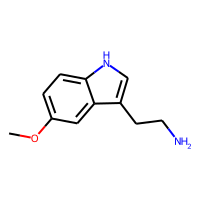

In [35]:
train_csv[['Smiles', 'Molecule']].head(1)

In [36]:
from molvecgen.vectorizers import SmilesVectorizer

In [37]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)

In [38]:
smivec

In [39]:
len(train_csv.Molecule.values)

5557

In [40]:
smivec.fit(train_csv.Molecule.values, )

In [41]:
y = train_csv.Active.values.reshape((-1,1))
X = train_csv.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)
#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [42]:
# wrapping a SMILES vectorizer in a dataset
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        mols = self.molecules[idx]
        # The vectorizer was written to work with batches, 
        # but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        sample = torch.Tensor(sample).to(torch.float32)
        label = torch.Tensor([label]).to(torch.float32)
        return sample, label

,Unnamed: 0,Smiles,Active,Molecule
0,0,COc1ccc2[nH]cc(CCN)c2c1,False,
1,1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False,
2,2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False,
3,3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False,
4,4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False,
5,5,NN=C(N)N,False,
6,6,CCCCCCCCCCCCCCCC(=O)O,False,
7,7,O=C(Nc1nc2ccccc2s1)c1cccc(C(Cl)(Cl)Cl)c1,False,
8,8,Cl.OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1,False,
9,9,CC(=O)N(O)C/C=C/c1cccc(Oc2ccccc2)c1,False,

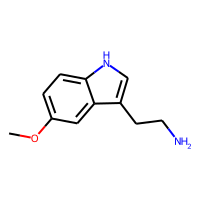
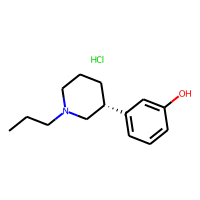
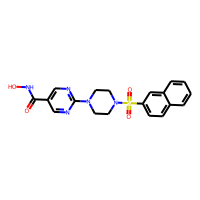
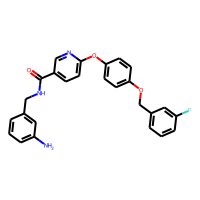
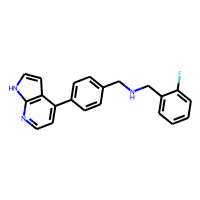
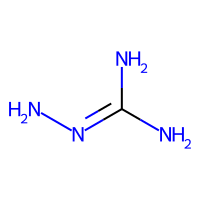
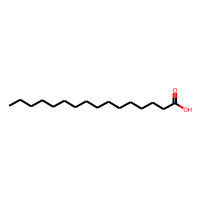
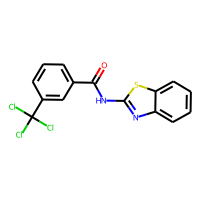
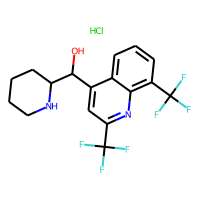
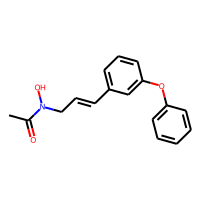
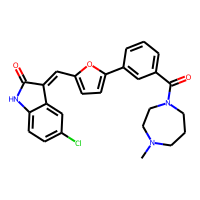
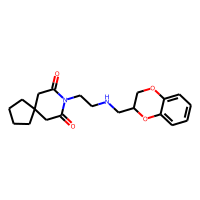
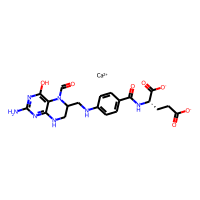
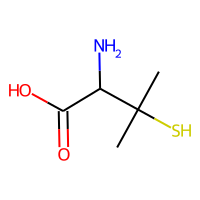
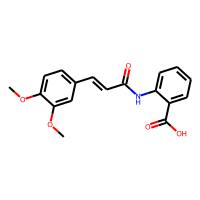
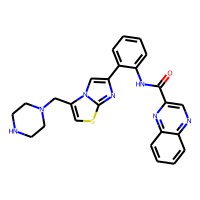
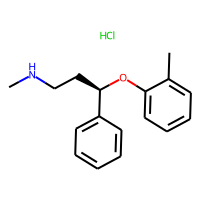
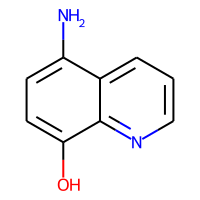
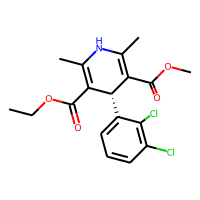
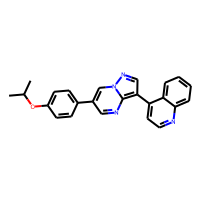
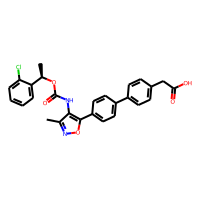
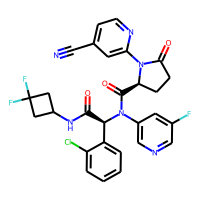
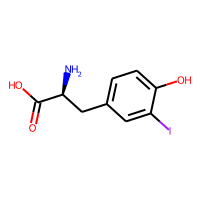
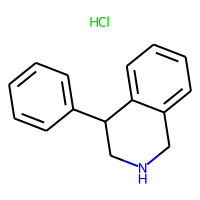
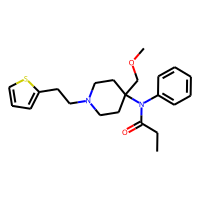
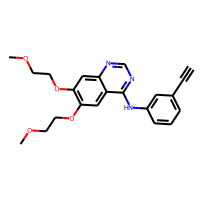
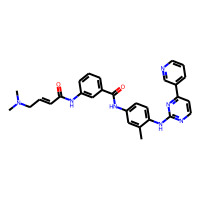
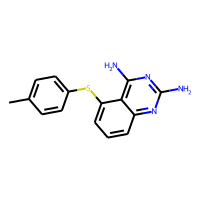
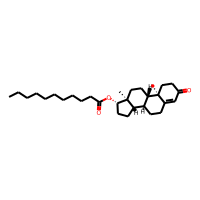
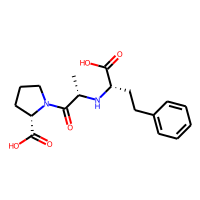
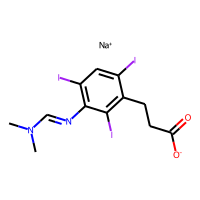
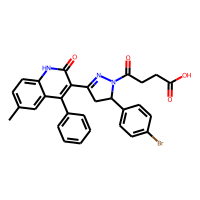
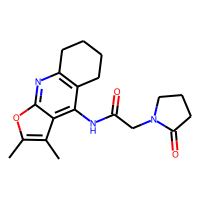
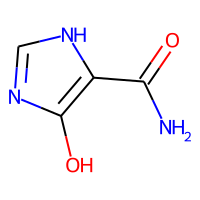
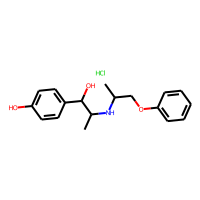
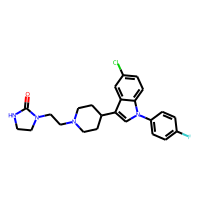
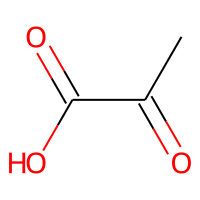
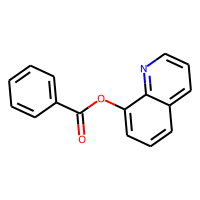
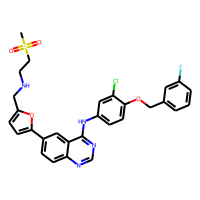
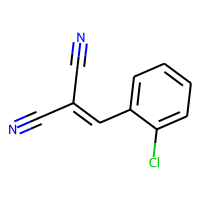
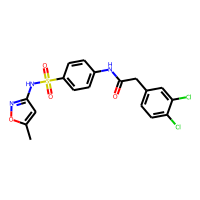
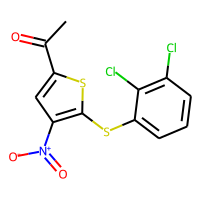
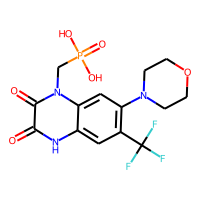
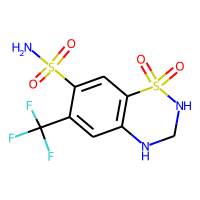
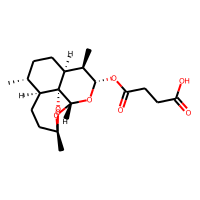
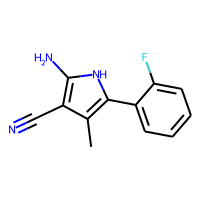
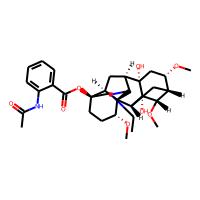
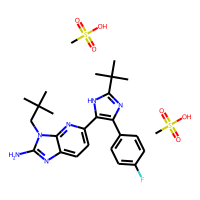
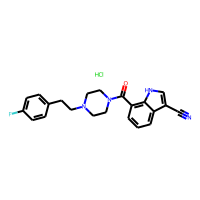
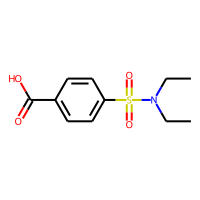
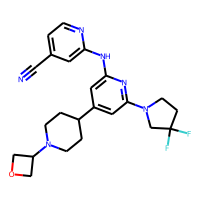
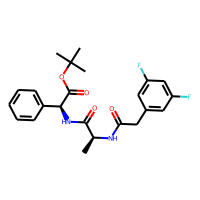
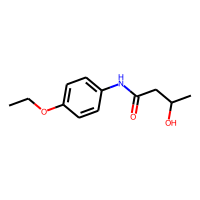
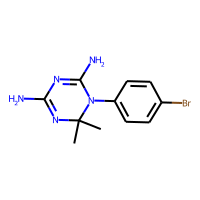
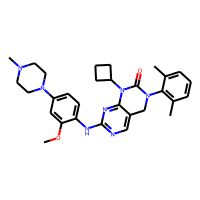
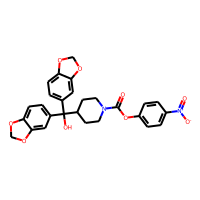
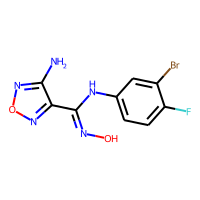
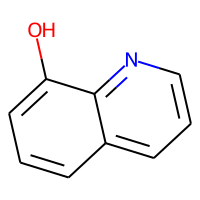
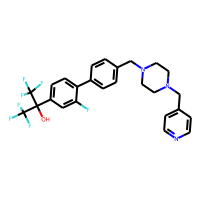
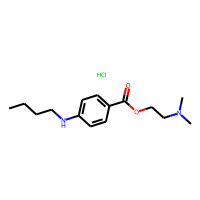

In [43]:
train_csv

In [44]:
def create_folds(data, num_splits=3):
    if num_splits > 1:
        data.loc[:,'kfold'] = -1
        X = data['Smiles']
        y = data['Active']
        mskf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

        for fold, (trn_, val_) in enumerate(mskf.split(X,y)):
            data.loc[val_,'kfold'] = fold
    else:
        data.loc[:,'kfold'] = 0
    return data

df = create_folds(train_csv, num_splits = config["n_fold"])

In [45]:
def prepare_loaders(fold):
    df_train = df[df["kfold"]!= fold]
    df_val = df[df["kfold"]==fold]
    
    train_dataset = SMILESMolDataset(df_train.Molecule.values, df_train.Active.values, smivec)
    
    val_dataset = SMILESMolDataset(df_val.Molecule.values, df_val.Active.values, smivec)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['train_batch_size'], 
                                               shuffle=True, num_workers = 2, pin_memory=True, drop_last=True)
    
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config['val_batch_size'], 
                                             num_workers = 2, shuffle=True, pin_memory=True, drop_last=True)
    
    return train_loader, val_loader

In [59]:
def fetch_scheduler(optimizer):
    if config['scheduler'] == 'cosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=config['T_max'], eta_min=config['min_lr'])
    
    elif config['scheduler'] == 'cosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=config['T_0'], eta_min=config['min_lr'])
        
    elif config['scheduler'] == None:
        return None
    
    return scheduler

## Defining molecular LSTM class

In [60]:
class Net(nn.Module):
    def __init__(self, dims, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
         
        length = dims[0]
        number_tokens = dims[1]
     
        self.lstm = nn.LSTM(input_size=number_tokens, 
                            hidden_size=lstm_size, num_layers=1, 
                            batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer       
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):# Forward pass: stacking each layer together
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) # Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

## Training

In [61]:
def train_one_epoch(model, optimizer, dataloader, 
                    scheduler, device, epoch,
                   criterion = config['criterion']):
    model.train()
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(dataloader), total = len(dataloader))
    
    for itnum, (smiles, labels) in bar:   
        # Push numpy to CUDA tensors 
        smiles = smiles.to(device)
        labels = labels.flatten().to(device)
        # print("LABELS DATA TYPE {}".format(labels.dtype))
        # print("LABELS: ", labels)
        
        batch_size = smiles.size(0)
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass

        output = model(smiles) #Forward pass of the mini-batch
        output = torch.flatten(torch.argmax(output, dim=0)).to(torch.float32)
        # print("OUTPUT DATA TYPE {output_dtype}".format(output_dtype=output.dtype))
        # print("OUTPUT train data: ", output)
        loss = criterion(output, labels) #Computing the loss
        loss.requires_grad_(requires_grad=True)
        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights
        
        if scheduler:
            scheduler.step()
            
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [62]:
def valid_one_epoch(model, dataloader, 
                    device, epoch,
                   criterion = config['criterion']):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(dataloader), total = len(dataloader))
    
    for itnum, (smiles, labels) in bar:
        with torch.no_grad():
            # Push numpy to CUDA tensors 
            # smiles = torch.tensor(smiles, device=device).float()
            # labels = torch.tensor(labels, device=device).to(torch.float16)
            smiles = smiles.to(device)
            labels = labels.flatten().to(device)
            batch_size = smiles.size(0)
            
            batch_size = smiles.size(0)
            outputs = model(smiles).to(torch.float32)
            outputs = torch.flatten(torch.argmax(outputs, dim=0)).to(torch.float32)
            loss = criterion(outputs, labels)
            loss.requires_grad_(requires_grad=True)
            
            running_loss += (loss.item() * batch_size)
            dataset_size += batch_size
        
            epoch_loss = running_loss / dataset_size
        
            bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [63]:
def train(model,
          device,
          train_loader,
          val_loader,
          optimizer,
          scheduler,
          num_epochs : int = 1000,
         criterion = config['criterion']):
    
    if torch.cuda.is_available():
        print("Using GPU :) ==> {}".format(torch.cuda.get_device_name()))
    history = defaultdict(list)
    patience_counter = 0
    best_epoch_loss = np.inf
    start = time.time()
    
    for epoch in range(num_epochs):
        gc.collect()
        
        train_epoch_loss =  train_one_epoch(model, optimizer, dataloader = train_loader, 
                                            scheduler = scheduler, device = config['device'], epoch = epoch)
        
        val_epoch_loss = valid_one_epoch(model,dataloader = val_loader,
                                         device = config['device'], epoch=epoch)
        
        history["train_loss"].append(train_epoch_loss)
        history["val_loss"].append(val_epoch_loss)
        
        if val_epoch_loss <= best_epoch_loss:
            print(f"Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, f'Loss-Fold-{fold}-full_model.pth')
            
            # Save a model file from the current directory
            print(f"Model Saved")
            
            
        else:
            patience_counter += 1
            print(f'Early stopping counter {patience_counter} of {config["early_stopping_epochs"]}')
            if patience_counter == config['early_stopping_epochs']:
                print('*************** Early Stopping ***************')
                break    
            
        # TODO Добавить early stopping !!!!!!!!!!!!!
        # Добавлено =) 
            
        print()
        
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [64]:
# looping through folds
for fold in range(0, config['n_fold']):
    train_loader, val_loader = prepare_loaders(fold)
    
    model = Net(smivec.dims, config['lstm_size'], 
        config['hidden_size'], config['dropout_rate'], 
        config['output_size'])
    model.to(config['device'])
    
    # Define Optimizer and Scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], 
                                 weight_decay=config['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = train(model, config['device'],
                           train_loader, val_loader,
                           optimizer, scheduler,
                           num_epochs=config['num_epochs'])
    
    del model, history, train_loader, val_loader
    _ = gc.collect()

Using GPU :) ==> Tesla V100-SXM2-32GB


  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (inf ---> 3.7828947368421053)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.7828947368421053 ---> 3.7280701754385963)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.7280701754385963 ---> 3.7280701754385963)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.7280701754385963 ---> 3.7280701754385963)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.7280701754385963 ---> 3.7280701754385963)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 1 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 2 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 3 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 4 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.7280701754385963 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 5 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 6 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 7 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 8 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 9 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 10 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 11 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 12 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 13 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 14 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 15 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 16 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 17 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 18 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 19 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 20 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 21 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 22 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 23 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 24 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 25 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 26 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 27 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 28 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 29 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 30 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 31 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 32 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 33 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 34 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 35 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 36 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 37 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 38 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 39 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 40 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 41 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 42 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 43 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 44 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6732456140350878)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 45 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 46 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 47 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 48 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6732456140350878 ---> 3.6184210526315788)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6184210526315788 ---> 3.6184210526315788)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 49 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
100%|████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 75.23it/s, Epoch=71, LR=0.000204, Train_Loss=30.5]
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-pack

Early stopping counter 50 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 51 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 52 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 53 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6184210526315788 ---> 3.6184210526315788)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 54 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 55 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 56 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 57 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 58 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 59 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 60 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 61 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 62 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 63 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 64 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 65 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 66 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 67 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 68 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 69 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 70 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 71 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 72 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 73 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 74 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 75 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 76 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 77 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 78 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 79 of 100



/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
100%|█████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 73.57it/s, Epoch=102, LR=0.000391, Train_Loss=3.78]


Early stopping counter 80 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 81 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 82 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 83 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 84 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 85 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 86 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6184210526315788 ---> 3.6184210526315788)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 87 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 88 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 89 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 90 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 91 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 92 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 93 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 94 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 95 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 96 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 97 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
100%|███████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 75.18it/s, Epoch=121, LR=0.000496, Train_Loss=31.7]
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-pack

Early stopping counter 98 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 99 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 100 of 100
*************** Early Stopping ***************
Training complete in 0h 5m 29s
Best Loss: 3.6184
Using GPU :) ==> Tesla V100-SXM2-32GB


  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (inf ---> 3.7828947368421053)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.7828947368421053 ---> 3.7280701754385963)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 1 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.7280701754385963 ---> 3.6184210526315788)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 2 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 3 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 4 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 5 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 6 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 7 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 8 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 9 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 10 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 11 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6184210526315788 ---> 3.6184210526315788)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 12 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6184210526315788 ---> 3.6184210526315788)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 13 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 14 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 15 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 16 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 17 of 100



/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
100%|████

Early stopping counter 18 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 19 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 20 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 21 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 22 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 23 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 24 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 25 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 26 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 27 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 28 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 29 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 30 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 31 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 32 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 33 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 34 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 35 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 36 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 37 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 38 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 39 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 40 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 41 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 42 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 43 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 44 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6184210526315788 ---> 3.6184210526315788)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6184210526315788 ---> 3.6184210526315788)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 45 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 46 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 47 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 48 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6184210526315788 ---> 3.6184210526315788)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 49 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 50 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 51 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 52 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 53 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 54 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (3.6184210526315788 ---> 3.56359649122807)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 55 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 56 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 57 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 58 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 59 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 60 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 61 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 62 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 63 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 64 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 65 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 66 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 67 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 68 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 69 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 70 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 71 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 72 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 73 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 74 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 75 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 76 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 77 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 78 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 79 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 80 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 81 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 82 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 83 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 84 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 85 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 86 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 87 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 88 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 89 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 90 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 91 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 92 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 93 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 94 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 95 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 96 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 97 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 98 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 99 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 100 of 100
*************** Early Stopping ***************
Training complete in 0h 4m 49s
Best Loss: 3.5636
Using GPU :) ==> Tesla V100-SXM2-32GB


  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (inf ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 1 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 2 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 3 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 4 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 5 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 6 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 7 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 8 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 9 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
100%|███████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 75.38it/s, Epoch=18, LR=0.00035, Train_Loss=61]
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
100%|███████████████████████████████████████████████████████████████████| 57/

Early stopping counter 10 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 11 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 12 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 13 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 14 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 15 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 16 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 17 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 18 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 19 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 20 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 21 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 22 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 23 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 24 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 25 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 26 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 27 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 28 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 29 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 30 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 31 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 32 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 33 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 34 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 35 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 36 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 37 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 38 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 39 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 40 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 41 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 42 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 43 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 44 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
100%|████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 75.30it/s, Epoch=78, LR=0.000465, Train_Loss=60.8]
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
100%|██████████████████████████████████████████████████████████████████| 57/5

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 45 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 46 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 47 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 48 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 49 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 50 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 51 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 52 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 53 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 54 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 55 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 56 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 57 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 58 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 59 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 60 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 61 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 62 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 63 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 64 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 65 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 66 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 67 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 68 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 69 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 70 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 71 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 72 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 73 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 74 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 75 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 76 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 77 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 78 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 79 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 80 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 81 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 82 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 83 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 84 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 85 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 86 of 100



/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
100%|████

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 87 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 88 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 89 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 90 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 91 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 92 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 93 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 94 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 95 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 96 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 97 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 98 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Validation Loss Improved (96.2719298245614 ---> 96.2719298245614)
Model Saved



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 99 of 100



  0%|                                                                                                                  | 0/115 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  0%|                                                                                                                   | 0/57 [00:00<?, ?it/s]/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/scratch/gsergei/anaconda3/envs/challenge_22feb_cov19/lib/python3.7/site-packa

Early stopping counter 100 of 100
*************** Early Stopping ***************
Training complete in 0h 6m 53s
Best Loss: 96.2719


In [86]:
X_train_T = torch.Tensor(smivec.transform(X_train, canonical=False)).float()
X_train_T = X_train_T.to(device)
X_validation_T = torch.Tensor(smivec.transform(X_validation)).float()
X_validation_T = X_validation_T.to(device)
X_test_T = torch.Tensor(smivec.transform(X_test)).float()
X_test_T = X_test_T.to(device)

model.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train = model(X_train_T)
y_pred_validation = model(X_validation_T)
y_pred_test = model(X_test_T)

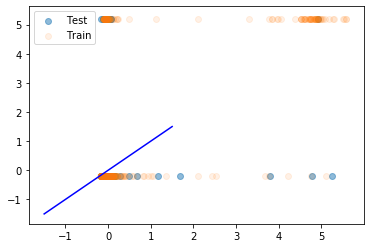

In [95]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

plt.scatter(flatten(y_pred_test), y_test.flatten(), alpha=0.5, label="Test")
plt.scatter(flatten(y_pred_train), y_train.flatten(), alpha=0.1, label="Train")
plt.legend()
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")

## Building Pandas dataframe with predicted activities

In [60]:
X_train_T = torch.Tensor(smivec.transform(X_train, canonical=False)).float()
X_train_T = X_train_T.to(device)
X_validation_T = torch.Tensor(smivec.transform(X_validation)).float()
X_validation_T = X_validation_T.to(device)
X_test_T = torch.Tensor(smivec.transform(X_test)).float()
X_test_T = X_test_T.to(device)

model = Net(dims, lstm_size, hidden_size, dropout_rate, output_size)
model.cuda()

model.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train = model(X_train_T)
y_pred_validation = model(X_validation_T)
y_pred_test = model(X_test_T)

In [62]:
state_dict = torch.load('/scratch/gsergei/checkpoints/challenge_22feb_cov19/cp_749.pth')

In [63]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [54]:
train_csv.columns

Index(['Unnamed: 0', 'Smiles', 'Active', 'Molecule'], dtype='object')

In [59]:
df_validation = train_csv[train_csv['Molecule'].isin(X_validation)]

In [65]:
pred_validation = model(X_validation_t)

,Unnamed: 0,Smiles,Active,Molecule
24,24,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCc2cccs2)CC1,False,
36,36,CN(C)c1nc(N)c(C(=O)Nc2cccnc2)nc1Cl,False,
41,41,Cn1nnc(-c2ccc(-c3ccc(N4C[C@H](COP(=O)(O)O)OC4=...,False,
50,50,CN1CCC(OC(c2ccccc2)c2ccccc2)CC1.Cl,False,
93,93,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,False,
96,96,O=C(O)CC(=O)C(=O)O,False,
118,118,COc1ccc2c(c1OC)C(=O)O[C@@H]2[C@H]1c2cc3c(cc2CC...,False,
176,176,COc1ccc(C[C@H](C)[C@H](C)Cc2ccc(OC)c(OC)c2)cc1OC,False,
194,194,CC[C@@H](CO)NCCN[C@@H](CC)CO,False,
203,203,CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc21,False,

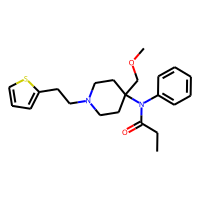
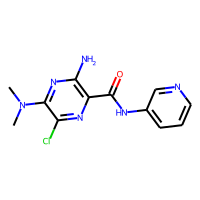
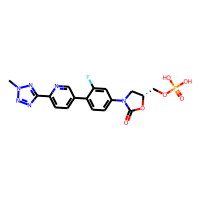
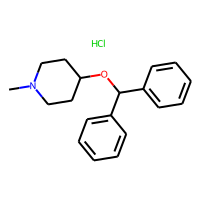
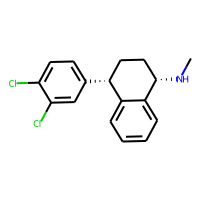
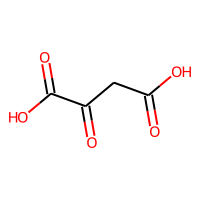
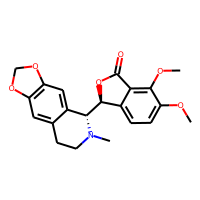
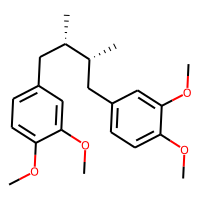
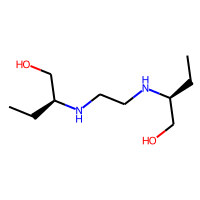
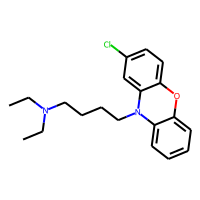
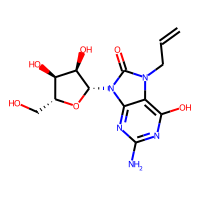
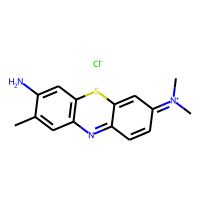
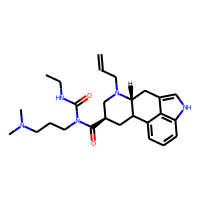
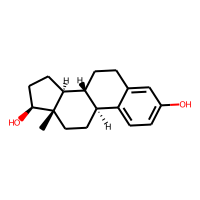
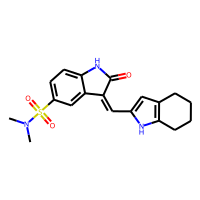
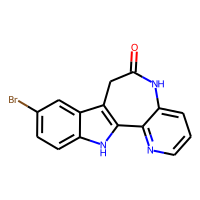
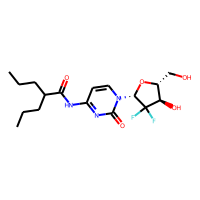
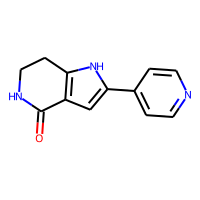
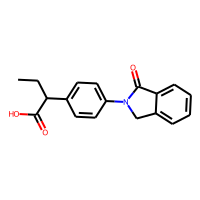
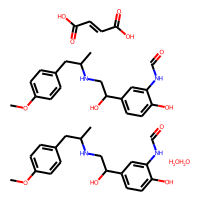
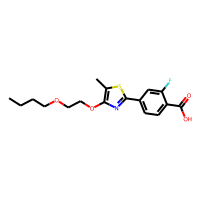
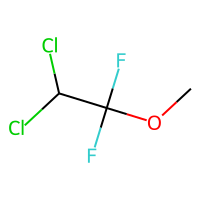
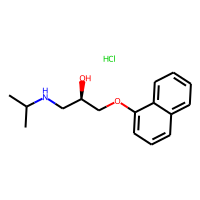
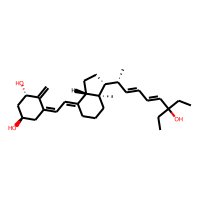
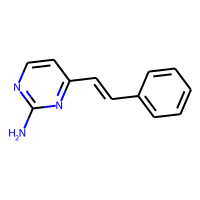
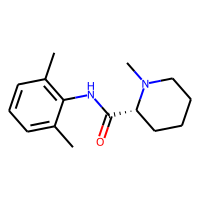
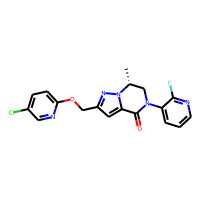
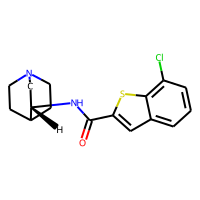
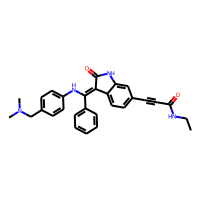
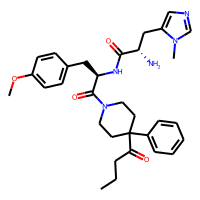
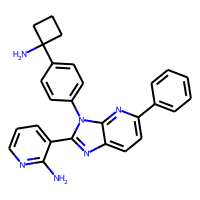
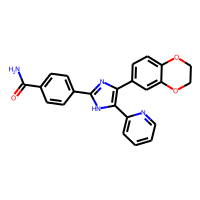
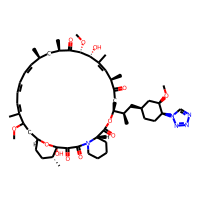
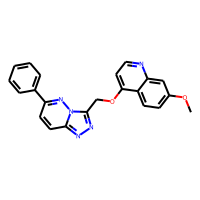
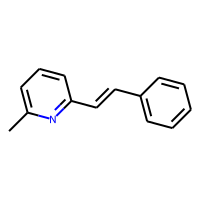
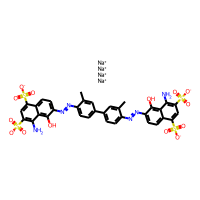
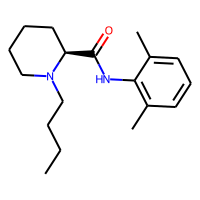
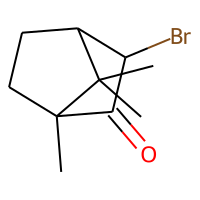
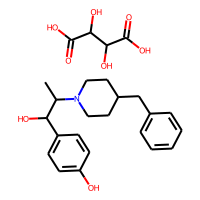
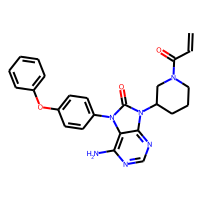
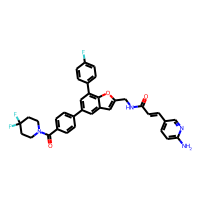
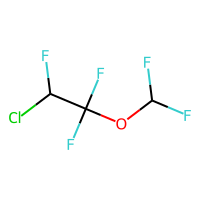
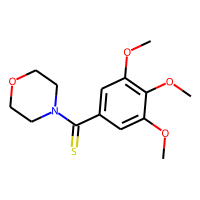
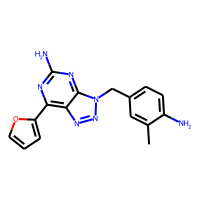
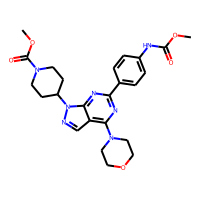
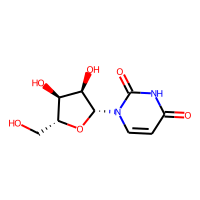
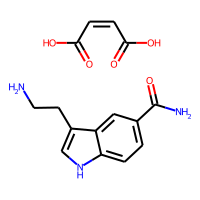
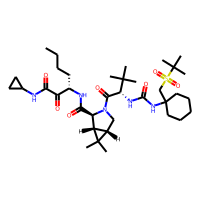
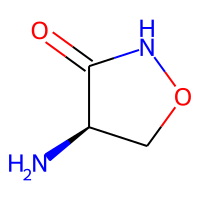
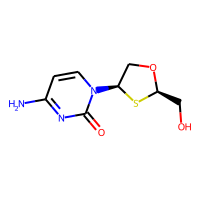
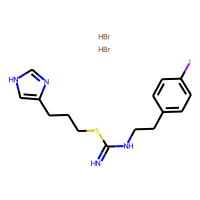
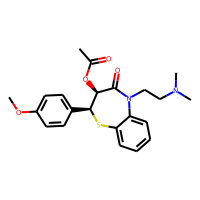
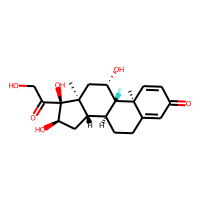
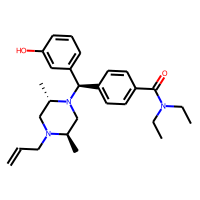
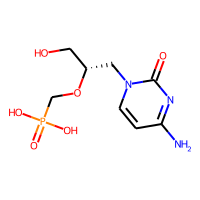
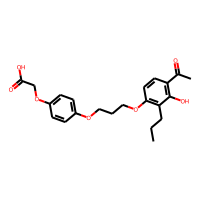
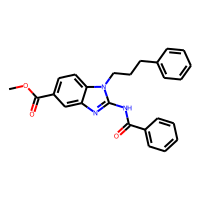
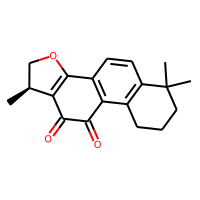
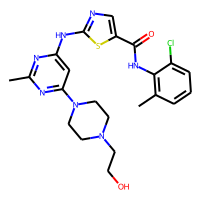
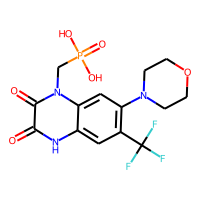

In [67]:
df_validation

In [66]:
pred_validation

tensor([[[-0.1677],
         [-0.1096],
         [-0.1166],
         [-0.1288],
         [-0.1182],
         [-0.1482],
         [-0.1713],
         [-0.1090],
         [-0.1647],
         [-0.1440],
         [-0.1143],
         [-0.0457],
         [-0.1436],
         [-0.0697],
         [-0.1319],
         [-0.1614],
         [-0.1410],
         [-0.1463],
         [-0.1067],
         [-0.1293],
         [-0.1185],
         [-0.1056],
         [-0.1137],
         [-0.1172],
         [-0.1181],
         [-0.1284],
         [-0.0796],
         [-0.0996],
         [-0.0913],
         [-0.1472],
         [-0.1809],
         [-0.1717],
         [-0.1148],
         [-0.1806],
         [-0.1576],
         [-0.1157],
         [-0.1210],
         [-0.1608],
         [-0.0952],
         [-0.1784],
         [-0.1498],
         [-0.1033],
         [-0.1130],
         [ 4.4386],
         [-0.1130],
         [-0.1295],
         [-0.1112],
         [-0.1277],
         [-0.1136],
         [-0.1198],


In [68]:
df_train = train_csv[train_csv['Molecule'].isin(X_train)]

In [71]:
df_train_true = df_train[df_train['Active'] == True]

In [72]:
pred_train = model(X_train_T)

In [75]:
len(pred_train[pred_train>0])

38

In [76]:
len(df_train_true)

169

In [78]:
PandasTools.AddMoleculeColumnToFrame(test_csv, 'Smiles', 'Molecule')

In [80]:
X_test = test_csv.Molecule.values

In [81]:
X_test

array([<rdkit.Chem.rdchem.Mol object at 0x2b913e8ba3f0>,
       <rdkit.Chem.rdchem.Mol object at 0x2b913e8baee0>, ...,
       <rdkit.Chem.rdchem.Mol object at 0x2b913ee99f80>], dtype=object)

In [87]:
X_test_T = smivec.transform(X_test, canonical=False)
X_test_T = torch.Tensor(X_test_T).float()
X_test_T = X_test_T.to(device)

,Unnamed: 0,Smiles,Molecule
0,0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,
1,1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,
2,2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,
3,3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,
4,4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,
5,5,CCOc1cc([C@@H](CS(C)(=O)=O)N2C(=O)c3cccc(NC(C)...,
6,6,CCN(CC)Cc1ccc(C(=O)N(CCc2ccccc2OC)[C@@H]2CCNC2...,
7,7,NC(=O)c1cccc(N)c1,
8,8,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2CCOC[C@H]2C(=O)N...,
9,9,CN(C)CCNC(=O)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(...,

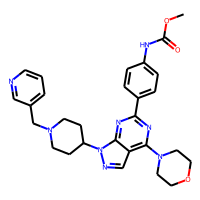
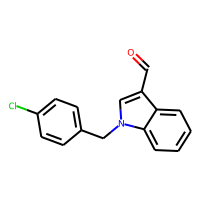
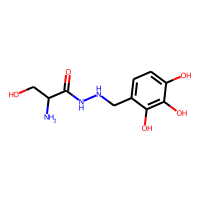
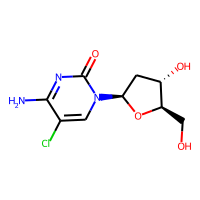
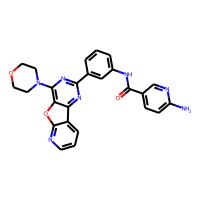
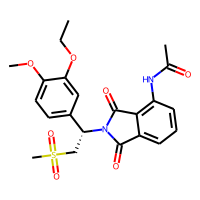
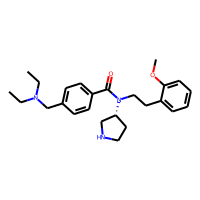
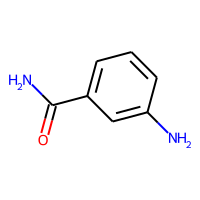
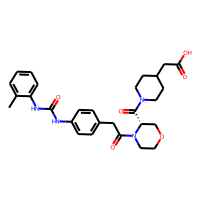
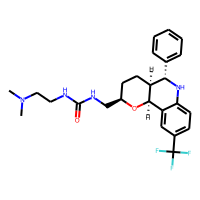
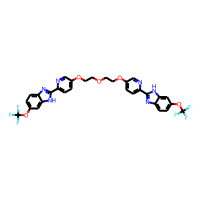
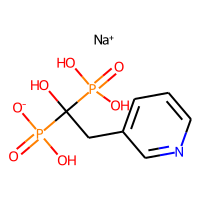
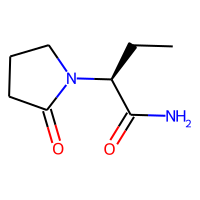
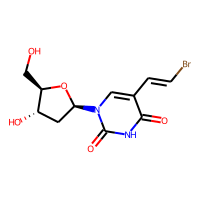
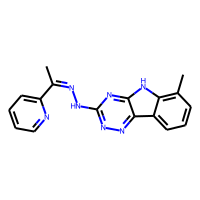
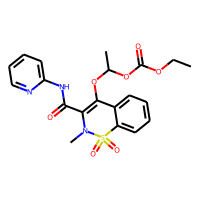
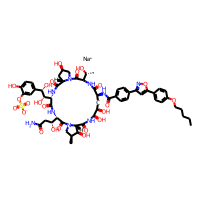
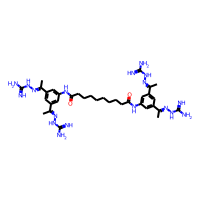
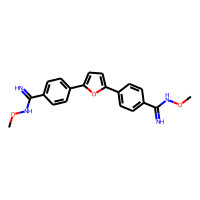
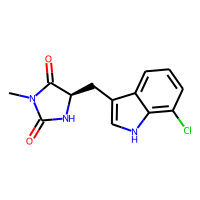
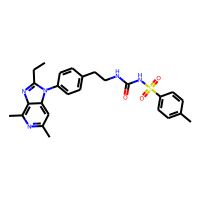
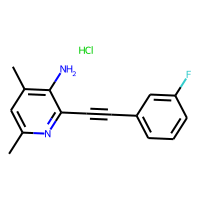
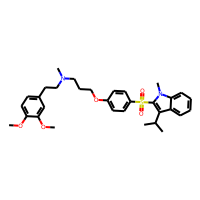
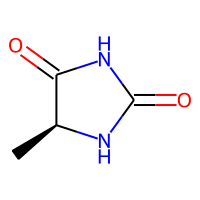
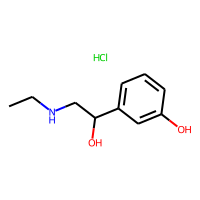
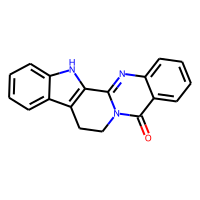
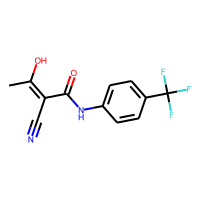
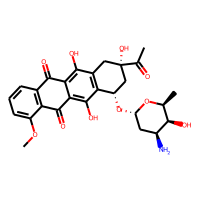
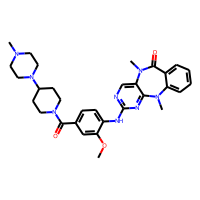
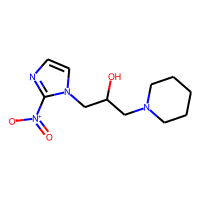
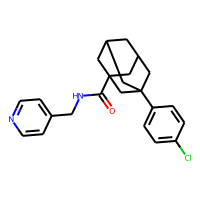
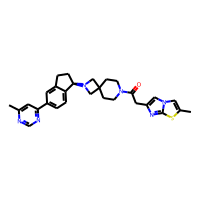
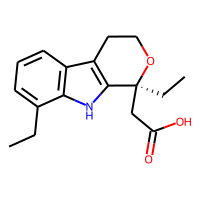
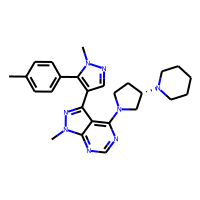
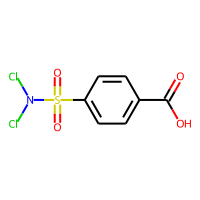
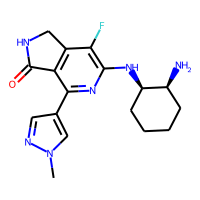
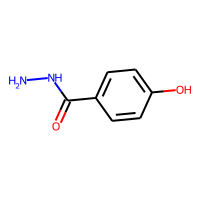
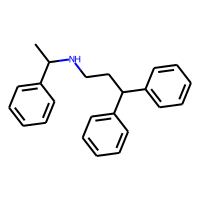
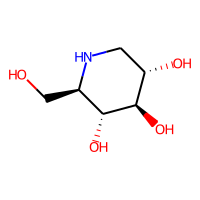
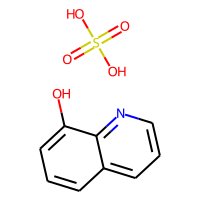
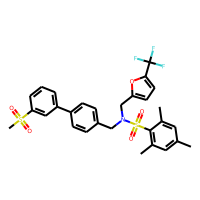
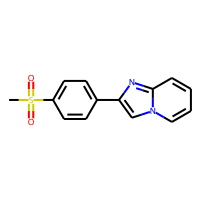
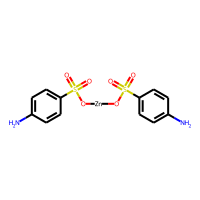
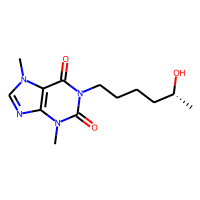
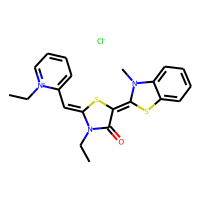
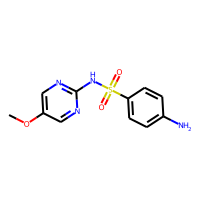
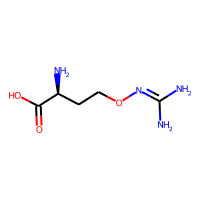
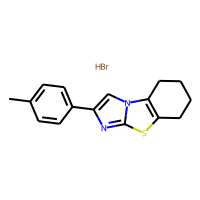
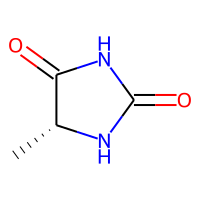
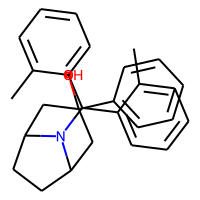
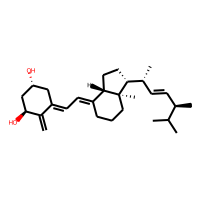
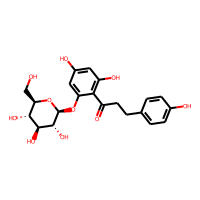
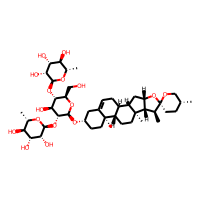
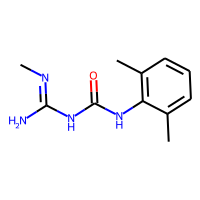
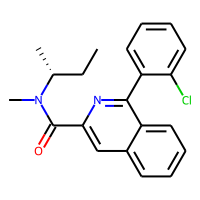
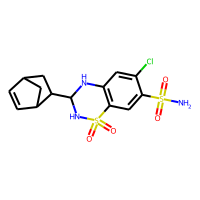
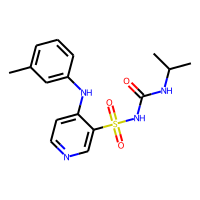
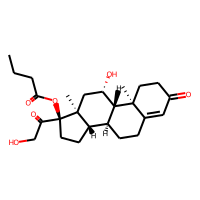
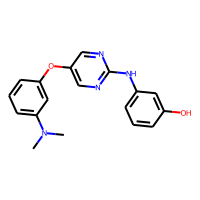
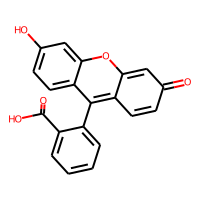

In [92]:
test_csv

In [90]:
pred_test = model(X_test_T)

In [98]:
pred_test_np = pred_test.cpu().detach().numpy()

In [99]:
pred_test_np[pred_test_np <= 0] = False
pred_test_np[pred_test_np > 0] = True

In [113]:
pred_test_np[0]

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [134]:
np.sum(pred_test_np)

10.0

In [124]:
map_bool = {0.:False, 1.:True}
pred_test_col = list(map(lambda x: map_bool[x], list(pred_test_np[0].T[0])))

In [129]:
test_csv_original = pd.read_csv('Task/test.csv')

In [130]:
test_csv_original['Active'] = pred_test_col

In [132]:
test_csv_original.rename(columns={'Unnamed:0':''})

,Unnamed: 0,Smiles,Active
0,0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,False
1,1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,False
2,2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,False
3,3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,False
4,4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,False
5,5,CCOc1cc([C@@H](CS(C)(=O)=O)N2C(=O)c3cccc(NC(C)...,False
6,6,CCN(CC)Cc1ccc(C(=O)N(CCc2ccccc2OC)[C@@H]2CCNC2...,False
7,7,NC(=O)c1cccc(N)c1,False
8,8,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2CCOC[C@H]2C(=O)N...,False
9,9,CN(C)CCNC(=O)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(...,False


In [133]:
test_csv_original.to_csv('raw_solution.csv', columns=['Smiles', 'Active'])

In [44]:
config['dims'] = smivec.dims
model = BiLSTM(config['dropout_rate'], config['hidden_size'], config['output_size'])
model.cuda()

NameError: name 'embedding_matrix' is not defined